In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np

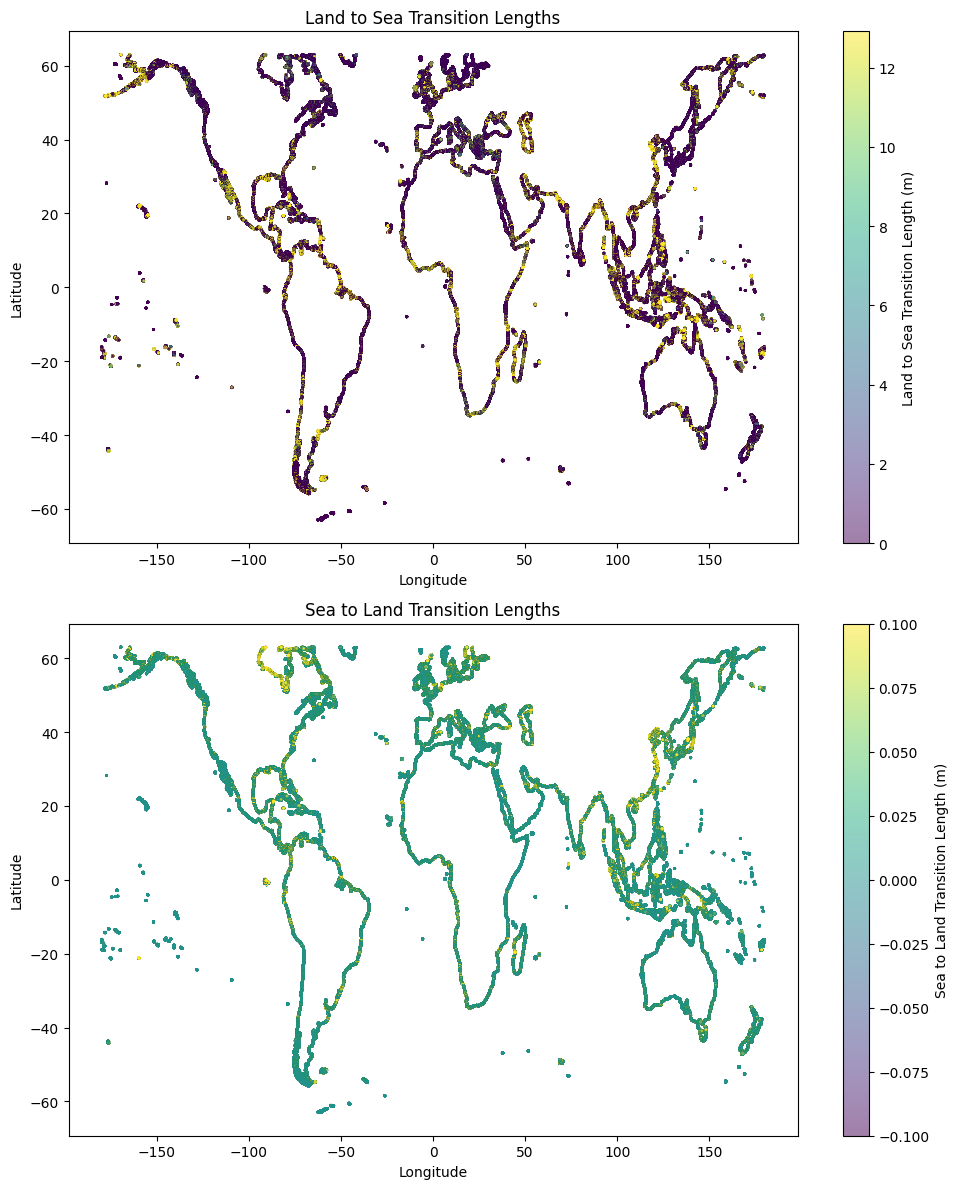

In [18]:
# Load the NetCDF file
dataset_path = '/rds/general/user/nassareh/home/main/mrc_funded/ranja/s01.data/s01.download/globalCoastalMorphodynamicsDb.nc'  # Update this to the path of your NetCDF file
ds = nc.Dataset(dataset_path)

# Read the variables based on the transect dimension
lat = ds.variables['lat'][:]
lon = ds.variables['lon'][:]
landtosea = ds.variables['landtosea'][:]
seatoland = ds.variables['seatoland'][:]

# Assuming the dataset might contain invalid data, filter out invalid points
valid_indices = (landtosea >= 0) & (seatoland >= 0)  # Adjust this condition based on your dataset's representation of invalid data

lat_valid = lat[valid_indices]
lon_valid = lon[valid_indices]
landtosea_valid = landtosea[valid_indices]
seatoland_valid = seatoland[valid_indices]

# Determine the range of your data for appropriate color scaling
vmin_landtosea = np.percentile(landtosea_valid, 5)
vmax_landtosea = np.percentile(landtosea_valid, 80)
vmin_seatoland = np.percentile(seatoland_valid, 5)
vmax_seatoland = np.percentile(seatoland_valid, 80)

# Visualization
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Land to Sea
sc1 = axs[0].scatter(lon_valid, lat_valid, c=landtosea_valid, cmap='viridis', s=1, alpha=0.5, vmin=vmin_landtosea, vmax=vmax_landtosea)
fig.colorbar(sc1, ax=axs[0], label='Land to Sea Transition Length (m)')
axs[0].set_title('Land to Sea Transition Lengths')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')

# Sea to Land
sc2 = axs[1].scatter(lon_valid, lat_valid, c=seatoland_valid, cmap='viridis', s=1, alpha=0.5, vmin=vmin_seatoland, vmax=vmax_seatoland)
fig.colorbar(sc2, ax=axs[1], label='Sea to Land Transition Length (m)')
axs[1].set_title('Sea to Land Transition Lengths')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

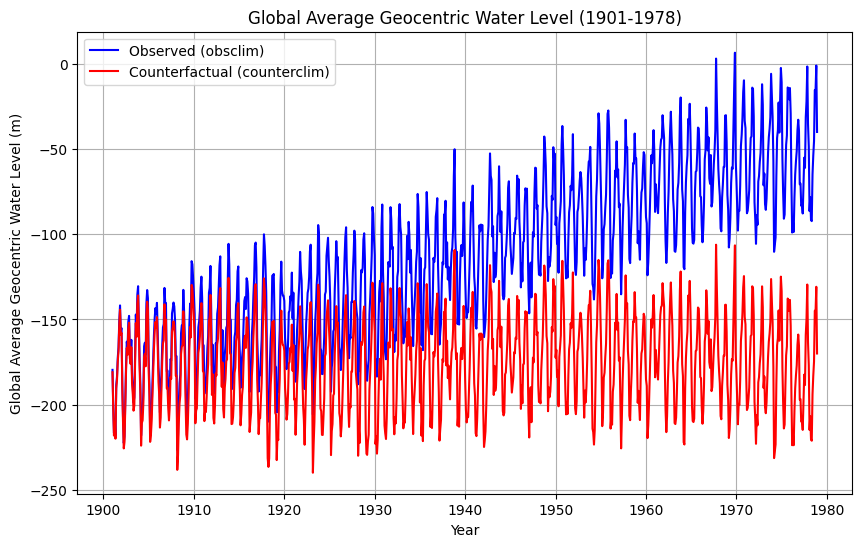

In [5]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np

def read_and_average(file_path):
    # Open the NetCDF file
    ds = nc.Dataset(file_path)
    
    # Read the geocentric water level data
    geocentric_water_level = ds.variables['geocentricwaterlevel'][:]
    
    # Calculate the global average for each time step
    global_average = np.nanmean(geocentric_water_level, axis=1)
    
    # Read the time variable
    time = ds.variables['time'][:]
    # Convert time to years (assuming the time unit is 'days since 1900-01-16')
    base_year = 1900
    days_in_year = 365.25  # Average, accounting for leap years
    years = base_year + time / days_in_year
    
    return years, global_average

# Paths to the NetCDF files
file_path_obsclim = '/rds/general/user/nassareh/home/main/mrc_funded/ranja/s01.data/s01.download/hcc_obsclim_geocentricwaterlevel_global_monthly_1901_1978.nc'
file_path_counterclim = '/rds/general/user/nassareh/home/main/mrc_funded/ranja/s01.data/s01.download/hcc_counterclim_geocentricwaterlevel_global_monthly_1901_1978.nc'

# Read and average the data
years_obsclim, avg_obsclim = read_and_average(file_path_obsclim)
years_counterclim, avg_counterclim = read_and_average(file_path_counterclim)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years_obsclim, avg_obsclim, label='Observed (obsclim)', color='blue')
plt.plot(years_counterclim, avg_counterclim, label='Counterfactual (counterclim)', color='red')

plt.title('Global Average Geocentric Water Level (1901-1978)')
plt.xlabel('Year')
plt.ylabel('Global Average Geocentric Water Level (m)')
plt.legend()
plt.grid(True)
plt.show()

/rds/general/user/nassareh/home/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


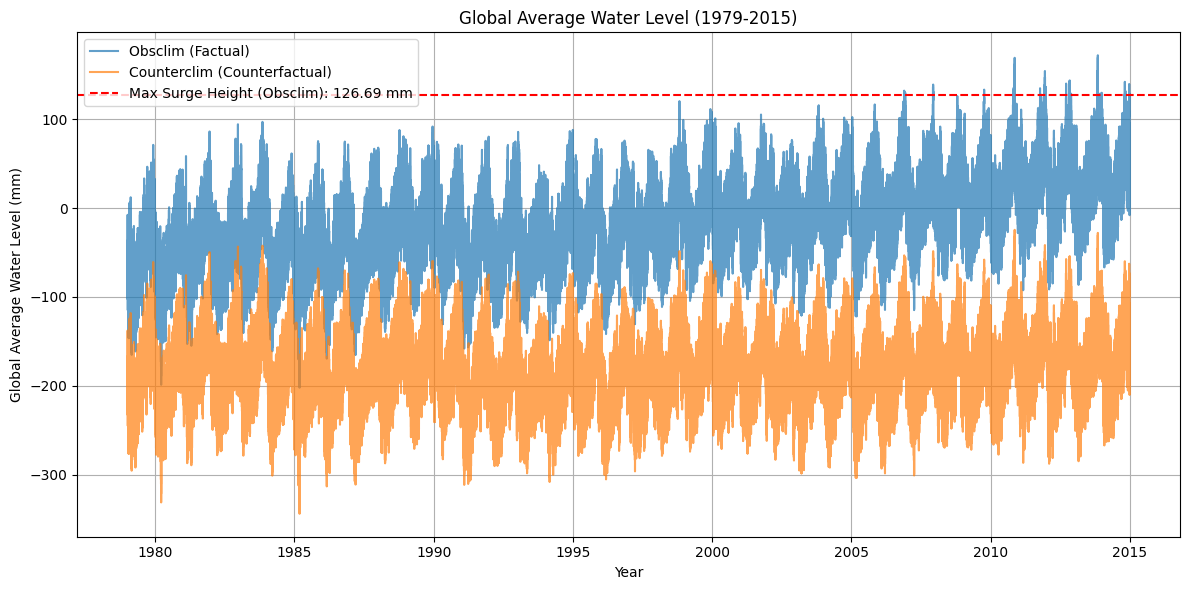

Maximum Surge Height for Obsclim: 126.69350397957744 mm
Maximum Surge Height for Counterclim: -69.54901494216553 mm


In [9]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import os

def global_average_for_year(file_path):
    ds = nc.Dataset(file_path)
    waterlevel = ds.variables['geocentricwaterlevel'][:]
    global_average = np.nanmean(waterlevel, axis=1)  # Average across all stations
    return global_average

def process_files_and_max_surge(base_path, pattern, years):
    global_averages = []
    max_surge_heights = []
    for year in years:
        file_path = os.path.join(base_path, pattern.format(year=year))
        yearly_average = global_average_for_year(file_path)
        global_averages.append(yearly_average)
        max_surge_heights.append(np.nanpercentile(yearly_average, 99))  # Calculate 99th percentile for each year
    return np.concatenate(global_averages), np.nanmax(max_surge_heights)  # Combine yearly data into a single array and get the max surge height

# Define the base path where your files are stored and the file naming pattern
base_path = '/rds/general/user/nassareh/home/main/mrc_funded/ranja/s01.data/s01.download/'  # Update this to your files' location
pattern_obsclim = 'hcc_obsclim_geocentricwaterlevel_global_hourly_{year}.nc'
pattern_counterclim = 'hcc_counterclim_geocentricwaterlevel_global_hourly_{year}.nc'
years = range(1979, 2015)  # Update the end year as needed

# Process the files and calculate global averages and max surge heights
global_avg_obsclim, max_surge_obsclim = process_files_and_max_surge(base_path, pattern_obsclim, years)
global_avg_counterclim, max_surge_counterclim = process_files_and_max_surge(base_path, pattern_counterclim, years)

# Now you have max_surge_obsclim and max_surge_counterclim for maximum surge height in each dataset

# Generate a time axis (assuming hourly data points starting from 1979-01-01)
total_hours = len(global_avg_obsclim)
time_axis = np.arange(total_hours) / 24 / 365.25 + 1979  # Convert hours to years

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_axis, global_avg_obsclim, label='Obsclim (Factual)', alpha=0.7)
plt.plot(time_axis, global_avg_counterclim, label='Counterclim (Counterfactual)', alpha=0.7)

# Add a dashed line for the maximum surge height of the observed sea level
plt.axhline(y=max_surge_obsclim, color='r', linestyle='--', label=f'Max Surge Height (Obsclim): {max_surge_obsclim:.2f} mm')

plt.title('Global Average Water Level (1979-2015)')
plt.xlabel('Year')
plt.ylabel('Global Average Water Level (mm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print max surge heights
print(f"Maximum Surge Height for Obsclim: {max_surge_obsclim} mm")
print(f"Maximum Surge Height for Counterclim: {max_surge_counterclim} mm")

/rds/general/user/nassareh/home/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/rds/general/user/nassareh/home/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/var/tmp/pbs.9204444.pbs/ipykernel_2216939/3443054353.py:23: RuntimeWarning: All-NaN slice encountered
  percentile_surge_map = np.nanmax(np.array(all_percentiles), axis=0)


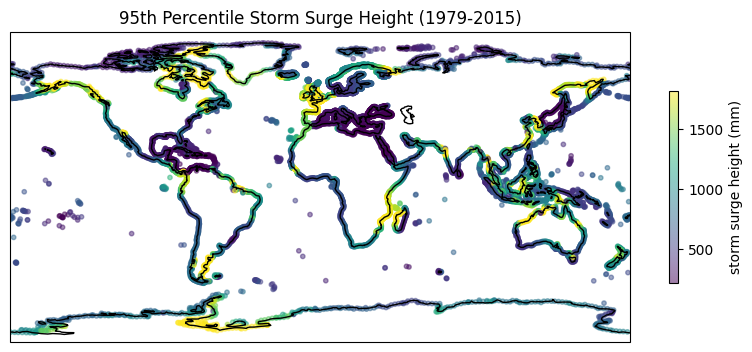

In [69]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs

def percentile_surge_for_year(file_path):
    ds = nc.Dataset(file_path)
    waterlevel = ds.variables['geocentricwaterlevel'][:]
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
    percentile_surge = np.nanpercentile(waterlevel, 95, axis=0)  # Compute 99th percentile
    return percentile_surge, lat, lon

def process_files_for_percentile_surge_map(base_path, pattern, years):
    # Initialize a list to store percentile surge data for all years
    all_percentiles = []
    for year in years:
        file_path = os.path.join(base_path, pattern.format(year=year))
        percentile_surge, lat, lon = percentile_surge_for_year(file_path)
        all_percentiles.append(percentile_surge)
    # Calculate the maximum of the 95th percentile surges across all years
    percentile_surge_map = np.nanmax(np.array(all_percentiles), axis=0)
    return percentile_surge_map, lat, lon

# Example usage parameters
base_path = '/rds/general/user/nassareh/home/main/mrc_funded/ranja/s01.data/s01.download/'
pattern = 'hcc_obsclim_geocentricwaterlevel_global_hourly_{year}.nc'
years = range(1979, 2015)  # Adjust as needed

# Get the 99th percentile surge map data along with latitudes and longitudes
percentile_surge_map, lat, lon = process_files_for_percentile_surge_map(base_path, pattern, years)

def plot_percentile_surge_map(percentile_surge_map, lat, lon):
    if percentile_surge_map is None:
        print("No valid surge data available to plot.")
        return
    plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_global()

    vmin = np.nanpercentile(percentile_surge_map, 90)
    vmax = np.nanpercentile(percentile_surge_map, 5)
    
    # Plotting
    scatter = ax.scatter(lon, lat, c=percentile_surge_map, s=10, cmap='viridis', alpha=0.5 , vmin = vmin, vmax = vmax)
    plt.colorbar(scatter, ax=ax, shrink=0.5, label='storm surge height (mm)')
    plt.title('95th Percentile Storm Surge Height (1979-2015)')
    plt.show()

# Plot the surge map if data is available
if percentile_surge_map is not None:
    plot_percentile_surge_map(percentile_surge_map, lat, lon)
else:
    print("Unable to plot the percentile surge map due to lack of valid data.")


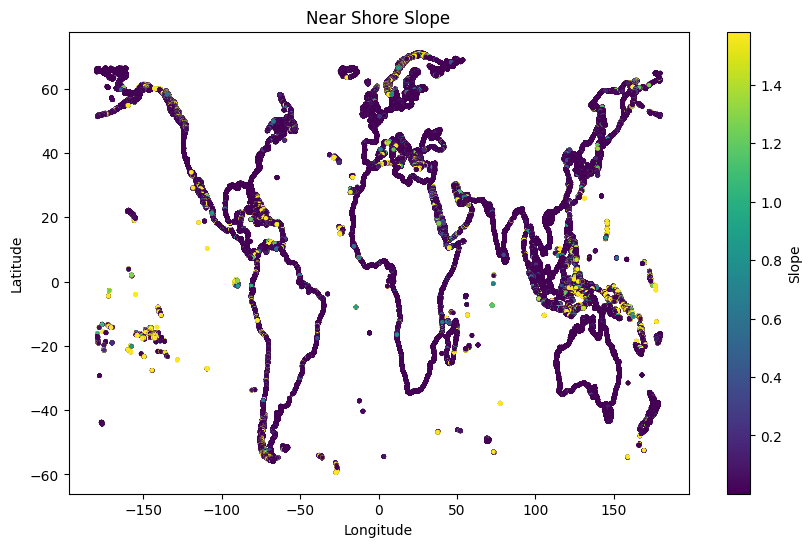

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

# Load the CSV data
df = pd.read_csv('/rds/general/user/nassareh/home/main/mrc_funded/ranja/s01.data/s01.download/near_shore_slopes.csv')

# Filter out rows with NaN values in the 'slope' column
df = df.dropna(subset=['slope'])

# Extract coordinates and slope values
X = df['X']
Y = df['Y']
slope = df['slope']

# Use percentiles to set the color scale limits
vmin = np.percentile(slope, 5)  # 5th percentile
vmax = np.percentile(slope, 95)  # 95th percentile

# Plot
plt.figure(figsize=(10, 6))
sc = ax.scatter(X, Y, c=slope, cmap='viridis', vmin=vmin, vmax=vmax, s=10, edgecolor='none')
plt.colorbar(sc, ax = ax, label='Slope')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Near Shore Slope')
plt.show()


/rds/general/user/nassareh/home/anaconda3/envs/test1/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


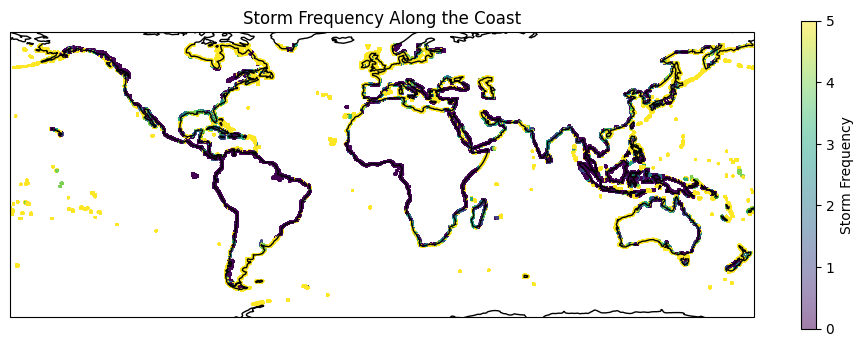

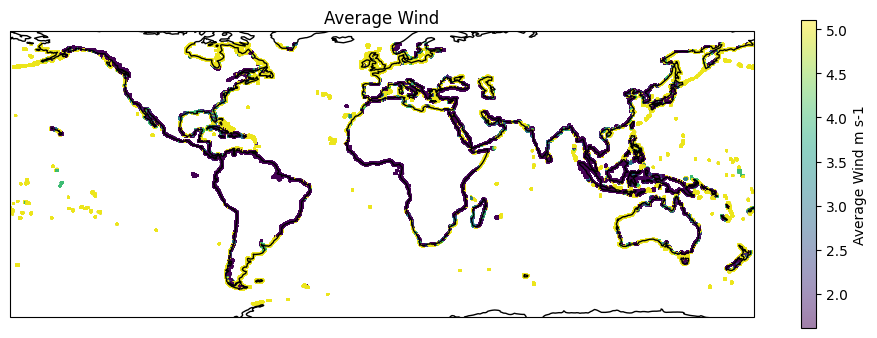

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs

def identify_coastal_cells(dataset_path):
    ds = nc.Dataset(dataset_path)
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
    landtosea = ds.variables['landtosea'][:]
    seatoland = ds.variables['seatoland'][:]
    
    valid_indices = (landtosea >= 0) & (seatoland >= 0)
    lat_valid = lat[valid_indices]
    lon_valid = lon[valid_indices]
    
    return lat_valid, lon_valid

def find_nearest_grid_points(lat_valid, lon_valid):
    xfirst = -179.75
    yfirst = 89.75
    xinc = 0.5
    yinc = -0.5  # Negative because latitude decreases

    # Use np.round for element-wise rounding and ensure it handles arrays
    ix = np.round((lon_valid - xfirst) / xinc).astype(int)
    iy = np.round((lat_valid - yfirst) / yinc).astype(int)

    # Clamp values to valid index ranges, handling arrays
    ix = np.clip(ix, 0, 719)  # 720 longitude points, index range is 0 to 719
    iy = np.clip(iy, 0, 359)  # 360 latitude points, index range is 0 to 359

    return iy, ix


def generate_filenames(base_path, parameter, years):
    filenames = []
    for start, end in years:
        filename = f"{parameter}_gswp3-w5e5_{start}_{end}.nc4"
        filenames.append(os.path.join(base_path, filename))
    return filenames

def process_climate_data(filenames, parameter, threshold, coastal_points):
    # Initialize storm counts grid with zeros, for coastal points
    storm_counts = np.zeros(coastal_points[0].shape)
    data_sums = np.zeros(coastal_points[0].shape)  # To store the sum of data values for each coastal point
    data_counts = np.zeros(coastal_points[0].shape)  # To count the number of observations for each coastal point
    
    # Prepare indices for advanced indexing
    iy, ix = coastal_points  # Assuming these are the precomputed indices for coastal cells
    
    for filename in filenames:
        ds = nc.Dataset(filename)
        data = ds.variables[parameter][:]  # shape is assumed to be [time, lat, lon]
        
        # Use advanced indexing to extract all coastal cell data at once
        coastal_data = data[:, iy, ix]  # This extracts the subset of data for all coastal cells across all times
     
        # Identify storm days for each coastal point and sum across the time dimension
        storm_days = coastal_data > threshold
        storm_event_counts = np.sum(storm_days, axis=0)  # Sum across the time dimension
        
        # Increment storm counts where there were any storm days
        storm_counts[storm_event_counts > 0] += 1
        
        # Accumulate sums and counts for average calculation
        data_sums += np.sum(coastal_data, axis=0)  # Sum of data values for averaging
        data_counts += coastal_data.shape[0]  # Counting all observations
        
    # Calculate average data values for each coastal point
    average_data = data_sums / data_counts
    
    return storm_counts, average_data

def plot_storm_frequency(storm_counts, coastal_points):
    # Correctly convert coastal point indices back to lat/lon for plotting
    xfirst = -179.75
    yfirst = 89.75
    xinc = 0.5
    yinc = -0.5  # Because latitude decreases
    
    # Adjust the calculation for lat/lon based on the grid definition
    lon_valid = xfirst + coastal_points[1] * xinc
    lat_valid = yfirst + coastal_points[0] * yinc
    
    vmin = np.percentile(storm_counts, 5)
    vmax = np.percentile(storm_counts, 80)
    
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    # Scatter plot for storm frequencies at coastal locations
    sc = ax.scatter(lon_valid, lat_valid, c=storm_counts, cmap='viridis', s=1, alpha=0.5,  vmin=vmin, vmax=vmax)
    plt.colorbar(sc, ax=ax, shrink = 0.5, label='Storm Frequency')
    plt.title('Storm Frequency Along the Coast')
    plt.show()
    
def plot_wind(average_wind, coastal_points):
    # Correctly convert coastal point indices back to lat/lon for plotting
    xfirst = -179.75
    yfirst = 89.75
    xinc = 0.5
    yinc = -0.5  # Because latitude decreases
    
    # Adjust the calculation for lat/lon based on the grid definition
    lon_valid = xfirst + coastal_points[1] * xinc
    lat_valid = yfirst + coastal_points[0] * yinc
    
    vmin = np.percentile(average_wind, 5)
    vmax = np.percentile(average_wind, 80)
    
    plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    # Scatter plot for storm frequencies at coastal locations
    sc = ax.scatter(lon_valid, lat_valid, c=storm_counts, cmap='viridis', s=1, alpha=0.5,  vmin=vmin, vmax=vmax)
    plt.colorbar(sc, ax=ax, shrink = 0.5, label='Average Wind m s-1')
    plt.title('Average Wind')
    plt.show()
 
# Configuration and Execution
coastal_dataset_path = '/rds/general/user/nassareh/home/main/mrc_funded/ranja/s01.data/s01.download/globalCoastalMorphodynamicsDb.nc'
base_path = '/rds/general/user/nassareh/home/main/mrc_funded/ranja/s01.data/s01.download/climate'
years = [(1971, 1980), (1981, 1990), (1991, 2000), (2001, 2010), (2011, 2016)]
parameter = 'wind'  # Example parameter
threshold = 10  # Example threshold in m/s for identifying storms

lat_valid, lon_valid = identify_coastal_cells(coastal_dataset_path)
coastal_points = find_nearest_grid_points(lat_valid, lon_valid)
filenames = generate_filenames(base_path, parameter, years)
storm_counts, average_wind = process_climate_data(filenames, parameter, threshold, coastal_points)
plot_storm_frequency(storm_counts, coastal_points)
plot_wind(average_wind, coastal_points)


# Regridded and analysis
## correlation analysis
## Boosted regression tree model construction

In [1]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
import os
from scipy.interpolate import griddata
from scipy.stats import pearsonr
 
# Define the common grid
common_lat = np.arange(-90, 90, 0.2)
common_lon = np.arange(-180, 180, 0.2)
grid_lon, grid_lat = np.meshgrid(common_lon, common_lat)

def identify_coastal_cells(dataset_path):
    ds = nc.Dataset(dataset_path)
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
    landtosea = ds.variables['landtosea'][:]
    seatoland = ds.variables['seatoland'][:]
    
    valid_indices = (landtosea >= 0) & (seatoland >= 0)
    lat_valid = lat[valid_indices]
    lon_valid = lon[valid_indices]
    
    return lat_valid, lon_valid

def find_nearest_grid_points(lat_valid, lon_valid):
    xfirst = -179.75
    yfirst = 89.75
    xinc = 0.5
    yinc = -0.5  # Negative because latitude decreases

    # Use np.round for element-wise rounding and ensure it handles arrays
    ix = np.round((lon_valid - xfirst) / xinc).astype(int)
    iy = np.round((lat_valid - yfirst) / yinc).astype(int)

    # Clamp values to valid index ranges, handling arrays
    ix = np.clip(ix, 0, 719)  # 720 longitude points, index range is 0 to 719
    iy = np.clip(iy, 0, 359)  # 360 latitude points, index range is 0 to 359

    return iy, ix


# Function to interpolate any dataset onto the common grid
def interpolate_to_common_grid(data, lat, lon):
    grid_lon, grid_lat = np.meshgrid(common_lon, common_lat)
    interpolated_data = griddata((lon.flatten(), lat.flatten()), data.flatten(), (grid_lon, grid_lat), method='linear', fill_value=np.nan)
    return interpolated_data

# Process NetCDF data and interpolate
def process_and_interpolate_nc(file_path, var_name):
    ds = xr.open_dataset(file_path)
    data = ds[var_name][0, :].values  # Assume first timestep if time dimension exists
    lat = ds['lat'].values
    lon = ds['lon'].values
    interpolated_data = interpolate_to_common_grid(data, lat, lon)
    return interpolated_data

def generate_filenames(base_path, parameter, years):
    filenames = []
    for start, end in years:
        filename = f"{parameter}_gswp3-w5e5_{start}_{end}.nc4"
        filenames.append(os.path.join(base_path, filename))
    return filenames


def process_climate_data(filenames, parameter, threshold, coastal_points):
    # Initialize storm counts grid and sums for averages with zeros, for coastal points
    storm_counts = np.zeros(coastal_points[0].shape)
    data_sums = np.zeros(coastal_points[0].shape)  # To store the sum of data values for each coastal point
    data_counts = np.zeros(coastal_points[0].shape)  # To count the number of observations for each coastal point
    
    # Prepare indices for advanced indexing
    iy, ix = coastal_points  # Assuming these are the precomputed indices for coastal cells
    
    for filename in filenames:
        ds = nc.Dataset(filename)
        data = ds.variables[parameter][:]  # shape is assumed to be [time, lat, lon]
        
        # Use advanced indexing to extract all coastal cell data at once
        coastal_data = data[:, iy, ix]  # This extracts the subset of data for all coastal cells across all times
        
        # Identify storm days for each coastal point and sum across the time dimension
        storm_days = coastal_data > threshold
        storm_event_counts = np.sum(storm_days, axis=0)  # Sum across the time dimension
        
        # Increment storm counts where there were any storm days
        storm_counts += storm_event_counts
        
        # Accumulate sums and counts for average calculation
        data_sums += np.sum(coastal_data, axis=0)  # Sum of data values for averaging
        data_counts += coastal_data.shape[0]  # Counting all observations
    
    # Calculate average data values for each coastal point
    average_data = data_sums / data_counts
    
    return storm_counts, average_data


def calculate_storm_frequency_coastal_to_common_grid(storm_counts, lat_valid, lon_valid, common_lat, common_lon):
    # Prepare the coastal latitudes and longitudes for interpolation
    coastal_lat_lon = np.array(list(zip(lat_valid, lon_valid)))

    # Interpolate storm counts onto the common grid
    storm_frequency_common_grid = griddata(coastal_lat_lon, storm_counts, 
                                           (grid_lon, grid_lat), method='linear', fill_value=np.nan)
    return storm_frequency_common_grid

# Global variables file paths
surge_paths = [f'/rds/general/user/nassareh/home/main/mrc_funded/ranja/s01.data/s01.download/hcc_obsclim_geocentricwaterlevel_global_hourly_{year}.nc' for year in range(1979, 2016)]
land_to_sea_path = '/rds/general/user/nassareh/home/main/mrc_funded/ranja/s01.data/s01.download/globalCoastalMorphodynamicsDb.nc'
sea_to_land_path = land_to_sea_path  # Assuming the same file for land to sea and sea to land
slope_path = '/rds/general/user/nassareh/home/main/mrc_funded/ranja/s01.data/s01.download/near_shore_slopes.csv'

# Interpolate and aggregate surge height data
surge_data_all_years = []
for path in surge_paths:
    surge_data = process_and_interpolate_nc(path, 'geocentricwaterlevel')
    surge_data_all_years.append(surge_data)
surge_height_95th = np.nanpercentile(np.stack(surge_data_all_years, axis=0), 95, axis=0)

# Interpolate land to sea and sea to land transitions (assuming stored in variables `landtosea` and `seatoland`)
ds_trans = xr.open_dataset(land_to_sea_path)
land_to_sea = interpolate_to_common_grid(ds_trans['landtosea'].values, ds_trans['lat'].values, ds_trans['lon'].values)
sea_to_land = interpolate_to_common_grid(ds_trans['seatoland'].values, ds_trans['lat'].values, ds_trans['lon'].values)

# Process and interpolate slope data from CSV
df_slope = pd.read_csv(slope_path)
slope_interpolated = interpolate_to_common_grid(df_slope['slope'].values, df_slope['Y'].values, df_slope['X'].values)

# Configuration and Execution
coastal_dataset_path = '/rds/general/user/nassareh/home/main/mrc_funded/ranja/s01.data/s01.download/globalCoastalMorphodynamicsDb.nc'
base_path = '/rds/general/user/nassareh/home/main/mrc_funded/ranja/s01.data/s01.download/climate'
years = [(1971, 1980), (1981, 1990), (1991, 2000), (2001, 2010), (2011, 2016)]
parameter = 'wind'  # Example parameter
threshold = 15  # Example threshold in m/s for identifying storms

lat_valid, lon_valid = identify_coastal_cells(coastal_dataset_path)
coastal_points = find_nearest_grid_points(lat_valid, lon_valid)
filenames = generate_filenames(base_path, parameter, years)
storm_counts,average_wind  = process_climate_data(filenames, parameter, threshold, coastal_points)

storm_frequency_common_grid = calculate_storm_frequency_coastal_to_common_grid(
    storm_counts, lat_valid, lon_valid, common_lat, common_lon)
wind_common_grid =  calculate_storm_frequency_coastal_to_common_grid(
    average_wind, lat_valid, lon_valid, common_lat, common_lon)


/rds/general/user/nassareh/home/anaconda3/envs/test1/lib/python3.9/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.21.0 or higher is recommended. You are running version 2.4.1
  warnings.warn(
/rds/general/user/nassareh/home/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [2]:
import pandas as pd
import numpy as np

# Flatten the grid and data arrays for DataFrame construction
lat_flat = grid_lat.flatten()
lon_flat = grid_lon.flatten()
land_to_sea_flat = land_to_sea.flatten()
sea_to_land_flat = sea_to_land.flatten()
slope_interpolated_flat = slope_interpolated.flatten()
storm_frequency_flat = storm_frequency_common_grid.flatten()
surge_height_95th_flat = surge_height_95th.flatten()
wind_common_grid_flat = wind_common_grid.flatten()

# Create DataFrame
df = pd.DataFrame({
    'Latitude': lat_flat,
    'Longitude': lon_flat,
    'Land_to_Sea': land_to_sea_flat,
    'Sea_to_Land': sea_to_land_flat,
    'Slope': slope_interpolated_flat,
    'Storm_Frequency': storm_frequency_flat,
    'Surge_Height_95th': surge_height_95th_flat,
    'average_wind': wind_common_grid_flat
})

# Remove rows with NaN values in any column (considering only coastal areas with data in all fields)
df = df.dropna()

print(df.head())  # Show the first few rows of the DataFrame

# If you need to save this DataFrame for further analysis or sharing
df.to_csv("coastal_data_analysis.csv", index=False)


        Latitude  Longitude  Land_to_Sea  Sea_to_Land     Slope  \
276160     -59.4      -28.0          0.0          0.0  1.126324   
276161     -59.4      -27.8          0.0          0.0  2.489503   
276165     -59.4      -27.0          0.0          0.0  9.860645   
276166     -59.4      -26.8          0.0          0.0  5.805699   
276167     -59.4      -26.6          0.0          0.0  5.588698   

        Storm_Frequency  Surge_Height_95th  average_wind  
276160              0.0         452.720408      2.631832  
276161              0.0         452.024148      2.597572  
276165              0.0         450.209300      2.460533  
276166              0.0         452.185735      2.426273  
276167              0.0         454.162170      2.392014  


In [26]:
threshold_land_to_sea = df['Land_to_Sea'].quantile(0.5)

df_filtered = df[(df['Land_to_Sea'] > 0)]
df_filtered = df_filtered[(df_filtered['Land_to_Sea'] > threshold_land_to_sea)]
df_filtered = df_filtered[(df_filtered['Storm_Frequency'] > 0)]

# Calculate the Pearson correlation matrix for specific variables of interest
correlation_matrix = df_filtered[['Land_to_Sea', 'Surge_Height_95th', 'Slope']].corr()

# Display the correlation matrix focusing on relationships with Land_to_Sea
print(correlation_matrix)


                   Land_to_Sea  Surge_Height_95th     Slope
Land_to_Sea           1.000000           0.082329 -0.053856
Surge_Height_95th     0.082329           1.000000 -0.143200
Slope                -0.053856          -0.143200  1.000000


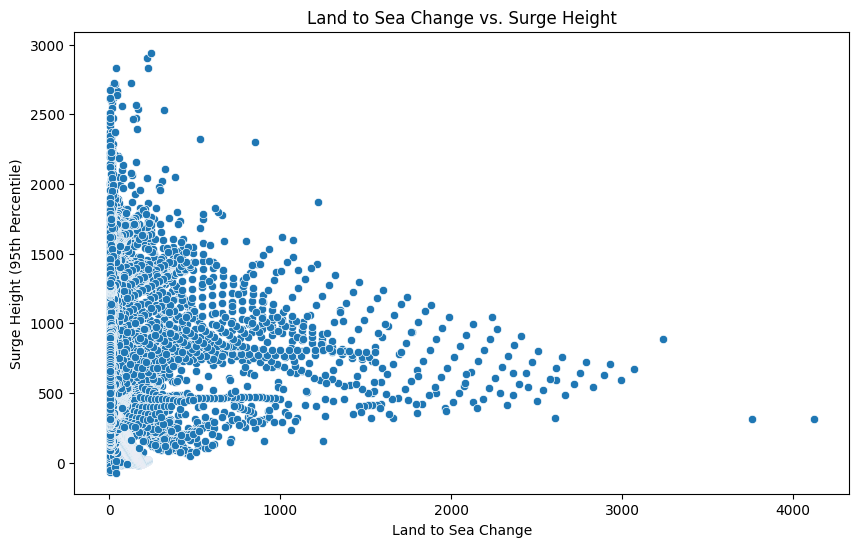

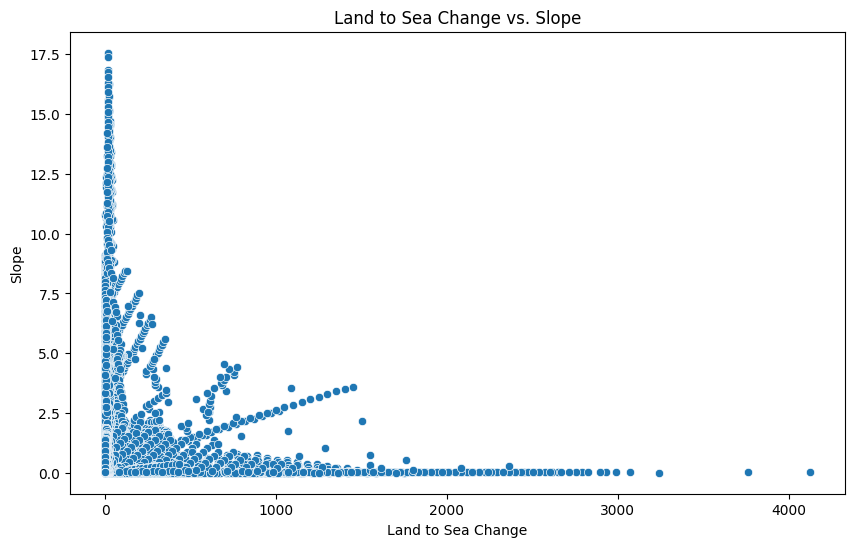

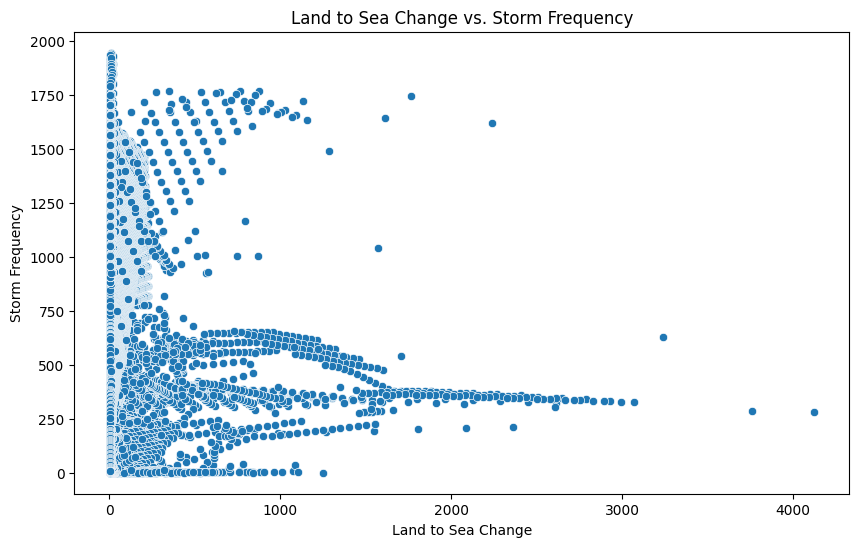

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Relationship between Land_to_Sea and Surge_Height_95th
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='Land_to_Sea', y='Surge_Height_95th')
plt.title('Land to Sea Change vs. Surge Height')
plt.xlabel('Land to Sea Change')
plt.ylabel('Surge Height (95th Percentile)')
plt.show()

# Relationship between Land_to_Sea and Slope
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='Land_to_Sea', y='Slope')
plt.title('Land to Sea Change vs. Slope')
plt.xlabel('Land to Sea Change')
plt.ylabel('Slope')
plt.show()


# Relationship between Land_to_Sea and Slope
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='Land_to_Sea', y='Storm_Frequency')
plt.title('Land to Sea Change vs. Storm Frequency')
plt.xlabel('Land to Sea Change')
plt.ylabel('Storm Frequency')
plt.show()





In [33]:
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame and already excludes NaN values

X = df_filtered[['Slope', 'Surge_Height_95th', 'Storm_Frequency']]  # Predictors
y = df_filtered['Land_to_Sea']  # Objective variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the model
model.fit(X_train, y_train)


In [31]:
# Predict on the testing set
y_pred = model.predict(X_test)

# Calculate the Mean Squared Error and R-squared value
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 4047.1279431208673
R-squared: 0.12762573589126602


In [32]:
# Feature importance
feature_importance = model.feature_importances_

# Print the name and importance of each feature
for feature, importance in zip(X.columns, feature_importance):
    print(f"{feature}: {importance}")


Slope: 0.25664141600780416
Surge_Height_95th: 0.256505102226611
Storm_Frequency: 0.48685348176558485
